In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from pprint import pprint

from warnings import filterwarnings
filterwarnings('ignore')

#### Helper Functions

In [31]:
# def model_and_evaluate(mode, plot=False):
    
#     # Names of models
#     model_labels = [
#         'LinearRegression',
#           'Lasso',
#           'Ridge',
#           'DecisionTreeRegressor',
#           'KNeighborsRegressor',
#           'MLPRegressor',
#           'RandomForestRegressor',
#           'XGBRegressor',
#           'XGBRFRegressor', 
# #           'SVR', 
#           'AdaBoostRegressor'            
#          ]

#     # Regression Models with default hyper-parameters
#     models = [
#         LinearRegression(),
#           Lasso(alpha=0.001),
#           Ridge(),
#           DecisionTreeRegressor(),
#           KNeighborsRegressor(weights='distance'),
#           MLPRegressor(random_state=42, max_iter=2000),
#           RandomForestRegressor(),
#           XGBRegressor(objective='reg:squarederror'),
#           XGBRFRegressor(objective='reg:squarederror', learning_rate=1), 
# #           SVR(C=500000), 
#           AdaBoostRegressor()
#     ]

#     r2_scores = []
#     mse_scores = []
#     mae_scores = []

#     for i, (model, name) in enumerate(zip(models, model_labels)):

#         accuracy = cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1)
        
        
# #         if mode == 'train':
# #             y_pred = model.predict(X_train)
# #             evaluation = y_train
# # #             print("On Training Data")
# #         elif mode == 'test':
# #             y_pred = model.predict(X_test)
# #             evaluation = y_test
# # #             print("On Testing Data")


# #         r2_scores.append()
# #         mse_scores.append(metrics.mean_squared_error(evaluation, y_pred))
# #         mae_scores.append(metrics.mean_absolute_error(evaluation, y_pred))  
        
#         if plot:
#             print(name, accuracy)
#             print("Mean Accuracy = {}".format(np.mean(accuracy)))
#             fig, ax = plt.subplots()
#             ax.plot(list(range(10)), accuracy)
#             ax.set_xlabel("Fold #")
#             ax.set_ylabel("Accuracy")
#             ax.set_title(name)
#             ax.set_ylim([0, 1])
#             plt.show()
        
# #     evaluation_df = pd.DataFrame({"model" : model_labels,
# #                                   "R-squared": r2_scores, 
# #                                   "MSE" : mse_scores, 
# #                                   "MAE" : mae_scores}).sort_values(by=['R-squared'], ascending=False)
    
    
    
# #     return evaluation_df.reset_index(drop=True).set_index('model')

In [27]:
# Read dataset
data = pd.read_csv("../../../Copper Dataset (version 3.0).csv")

# Split into features and target variables
X = data.iloc[:, :-2]
y = data['tensile_strength']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0005, random_state=37)  # (1029 in train/ 258 in test)

In [30]:
X_train.shape
X_test

bar  flat products & rod  flat products & wire  flat products, rod & bar  \
120    0                    0                     0                         0   

     forgings  pipe  plate  products  rod  rod & bar  ...   co   al   be   cr  \
120         0     0      0         1    0          0  ...  0.0  0.0  0.0  0.0   

      si   ti   ca   li    b    c  
120  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 120 columns]

In [32]:
# # Model using multiple techniques

# # Evaluate on training data
# train_eval = model_and_evaluate('train', plot=True)
# # print(train_eval)

# # # Evaluate on testing data
# # test_eval = model_and_evaluate('test')
# # print(test_eval)

# Best Models

In [33]:
# # Mask for models with R-squared score > 0.8
# mask = test_eval['R-squared'] > 0.8
# best_models = test_eval[mask].index.values

# # Display names of the best performing models
# print("Models with r-squared > 0.80 are :-\n")

# for i, model_name in enumerate(best_models):
#     print("{}. {}".format(i+1, model_name))

# Hyperparameter Tuning for each model

**1. Random Forest Regressor** 

a. Hyperparamter tuning with **RandomizedSearchCV**\
b. Hyperparamter tuning with **GridSearchCV**

#### Random Search Cross Validation

In [7]:
# Create grid for RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [8]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,   # 3 folds
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

We can view the **best parameters** from fitting the random search:

In [9]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

### Evaluate Random Search

To determine if random search yielded a better model, we **compare the base model** with the **best random search model**.

In [10]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    return accuracy


base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 4.9473 degrees.
Accuracy = 92.78%.

Model Performance
Average Error: 4.5930 degrees.
Accuracy = 93.31%.

Improvement of 0.57%.


In [12]:
model_name = "Random Forest Regressor"
y_pred = best_random.predict(X_test)

r2_scores = round(metrics.r2_score(y_test, y_pred), 4)
mse_scores = metrics.mean_squared_error(y_test, y_pred)
mae_scores = metrics.mean_absolute_error(y_test, y_pred)
        
evaluation_df = pd.DataFrame({"R-squared": r2_scores, 
                              "MSE" : mse_scores, 
                              "MAE" : mae_scores}, index=[model_name])

evaluation_df

R-squared        MSE       MAE
Random Forest Regressor      0.956  58.310642  4.592979

In [69]:
# model = best_random 

# importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")
# labels = []
# for f in range(X_train.shape[1]):
# #     print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
#     labels.append(X_train.columns[indices[f]])

# # Plot the feature importances of the forest
# plt.figure(figsize=(10,20))
# plt.title("Feature importances")
# plt.barh(labels, importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.yticks(ticks=labels)
# plt.ylim([-1, X.shape[1]])
# plt.show()

#### Grid Search Cross Validation

To use Grid Search, we **make another grid based on the best values provided by random search**

In [13]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 95, 100, 105, 110, 115, 120],
    'max_features': [2, 3, 4, 5, 'auto'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [1, 2, 3, 4],
    'n_estimators': [1300, 1400, 1450, 1500]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3200 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 64.6min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...e=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-

In [14]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 95,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1300}

In [15]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 4.5759 degrees.
Accuracy = 93.34%.

Improvement of 0.60%.


In [16]:
model_name = "Random Forest Regressor (Grid Search)"
y_pred = best_grid.predict(X_test)

r2_scores = round(metrics.r2_score(y_test, y_pred), 4)
mse_scores = metrics.mean_squared_error(y_test, y_pred)
mae_scores = metrics.mean_absolute_error(y_test, y_pred)
        
evaluation_df = pd.DataFrame({"R-squared": r2_scores, 
                              "MSE" : mse_scores, 
                              "MAE" : mae_scores}, index=[model_name])

evaluation_df

R-squared        MSE       MAE
Random Forest Regressor (Grid Search)     0.9564  57.774134  4.575869

In [17]:
# Create the parameter grid based on the results of random search 

param_grid = {
    'bootstrap': [True],
    'max_depth': [100],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [1400, 1500, 1600, 1700]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print best parameters
pprint(grid_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   13.0s remaining:   26.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   22.2s finished


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1700}


In [18]:
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

model_name = "Random Forest Regressor (Grid Search v. 2)"
y_pred = best_grid.predict(X_test)

r2_scores = round(metrics.r2_score(y_test, y_pred), 4)
mse_scores = metrics.mean_squared_error(y_test, y_pred)
mae_scores = metrics.mean_absolute_error(y_test, y_pred)
        
evaluation_df = pd.DataFrame({"R-squared": r2_scores, 
                              "MSE" : mse_scores, 
                              "MAE" : mae_scores}, index=[model_name])

evaluation_df

R-squared        MSE       MAE
Random Forest Regressor (Grid Search v. 2)     0.9563  57.887152  4.582805

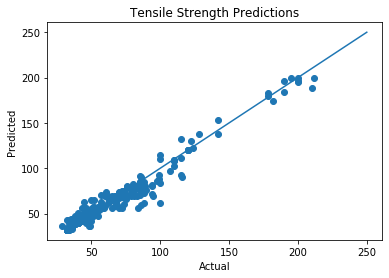

In [19]:
plt.scatter(y_test, y_pred)
plt.plot([50, 250], [50,250])
plt.title("Tensile Strength Predictions")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

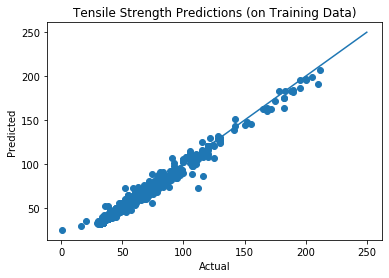

In [20]:
plt.scatter(y_train, best_grid.predict(X_train))
plt.plot([50, 250], [50,250])
plt.title("Tensile Strength Predictions (on Training Data)")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

In [1]:
data

NameError: name 'data' is not defined